In [37]:
import pandas as pd
import wandb
from tqdm.notebook import tqdm
import pickle
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MaxNLocator

from data.get_uci import all_datasets
from analysis.util import fetch, init_uci_dict, get_uci_info, COLORS, uci_markers
uci_info = get_uci_info()

In [2]:
filters = {
    "group": "inducing"
}
raw2 = fetch("soft-gp-2", filters)

100%|██████████| 136/136 [01:23<00:00,  1.64it/s]


In [3]:
runs = {}
uci_dict2 = {}
for exp in raw2:
    model = exp.config["model.name"]
    dataset = exp.config["dataset.name"]
    num_inducing = exp.config["model.num_inducing"]
    dtype = exp.config["model.dtype"]
    seed = exp.config["training.seed"]
    learn_noise = exp.config["model.learn_noise"]
    train_frac = float(exp.config["dataset.train_frac"])
    batch_size = exp.config["training.batch_size"]
    uci_dict2[(dataset, batch_size, num_inducing, model)] = exp.history
    runs[(dataset, batch_size, num_inducing, model)] = exp.run.id

print(uci_dict2.keys())

dict_keys([('keggdirected', 1024, 1536, 'soft-gp'), ('keggdirected', 1024, 256, 'soft-gp'), ('keggdirected', 1024, 128, 'soft-gp'), ('keggdirected', 1024, 4096, 'soft-gp'), ('keggdirected', 1024, 64, 'soft-gp'), ('keggdirected', 1024, 2048, 'soft-gp'), ('keggdirected', 1024, 1024, 'soft-gp'), ('keggdirected', 1024, 512, 'soft-gp'), ('protein', 1024, 1536, 'soft-gp'), ('protein', 1024, 128, 'soft-gp'), ('protein', 1024, 4096, 'soft-gp'), ('protein', 1024, 64, 'soft-gp'), ('protein', 1024, 2048, 'soft-gp'), ('protein', 1024, 1024, 'soft-gp'), ('protein', 1024, 512, 'soft-gp'), ('protein', 1024, 256, 'soft-gp'), ('kin40k', 1024, 1536, 'soft-gp'), ('kin40k', 1024, 128, 'soft-gp'), ('kin40k', 1024, 64, 'soft-gp'), ('bike', 1024, 1536, 'soft-gp'), ('bike', 1024, 128, 'soft-gp'), ('bike', 1024, 64, 'soft-gp'), ('kin40k', 1024, 4096, 'soft-gp'), ('kin40k', 1024, 2048, 'soft-gp'), ('elevators', 1024, 1536, 'soft-gp'), ('kin40k', 1024, 1024, 'soft-gp'), ('elevators', 1024, 128, 'soft-gp'), ('ele

In [29]:
UCI_INFO = {
    "N": [int(np.floor(N * 0.9)) for _, N, _, _ in uci_info],
    "D": [D for _, _, D, _ in uci_info],
    # "exact-rep": [e for _, _, _, e in uci_info],
}
KZZ = {}
all_bins = {}

seeds = [6535, 8830, 92357]
num_inducings = [64, 128, 256, 512, 1024, 1024 + 512, 2048, 4096]

# models = ["sv-gp"]
for seed in seeds:
    for num_inducing in num_inducings:
        model = "soft-gp"
        batch_size = 1024
        frac = 0.9
        xs = []
        ts = []
        K_zzs = []
        bins1 = []
        bins2 = []
        bins3 = []
        bins4 = []
        bins5 = []
        bins6 = []
        for dataset, _, _, _ in uci_info:
            try:
                xs += [float(uci_dict2[(dataset, batch_size, num_inducing, model)]["test_rmse"][49])]
                ts += [float(np.array(uci_dict2[(dataset, batch_size, num_inducing, model)]["epoch_time"][49]).mean())]
                K_zzs += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz"][i] for i in range(5)]
                bins1 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_0.0"][49]]
                bins2 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_1e-20"][49]]
                bins3 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_1e-10"][49]]
                bins4 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_1e-05"][49]]
                bins5 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_0.01"][49]]
                bins6 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_0.5"][49]]
            except Exception as e:
                xs += [np.nan]
                ts += [np.nan]
                bins1 += [np.nan]
                bins2 += [np.nan]
                bins3 += [np.nan]
                bins4 += [np.nan]
                bins5 += [np.nan]
                bins6 += [np.nan]
                print("Exception", e, model, dataset)

        UCI_INFO[f"{model}-{num_inducing}-{batch_size}-{seed}"] = xs
        # UCI_INFO[f"time-{model}-{num_inducing}-{batch_size}-{seed}"] = ts
        all_bins[f"0.0-{model}-{num_inducing}-{batch_size}-{seed}"] = bins1
        all_bins[f"1e-20-{model}-{num_inducing}-{batch_size}-{seed}"] = bins2
        all_bins[f"1e-10-{model}-{num_inducing}-{batch_size}-{seed}"] = bins3
        all_bins[f"1e-05-{model}-{num_inducing}-{batch_size}-{seed}"] = bins4
        all_bins[f"0.01-{model}-{num_inducing}-{batch_size}-{seed}"] = bins5
        all_bins[f"0.5-{model}-{num_inducing}-{batch_size}-{seed}"] = bins6
        KZZ[f"kzz-{model}-{num_inducing}-{batch_size}-{seed}"] = K_zzs
df = pd.DataFrame(data=UCI_INFO)
df.index = [name for name, _, _, _ in uci_info]
# df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

Exception ('slice', 1024, 64, 'soft-gp') soft-gp slice
Exception ('keggundirected', 1024, 64, 'soft-gp') soft-gp keggundirected
Exception ('3droad', 1024, 64, 'soft-gp') soft-gp 3droad
Exception ('song', 1024, 64, 'soft-gp') soft-gp song
Exception ('buzz', 1024, 64, 'soft-gp') soft-gp buzz
Exception ('houseelectric', 1024, 64, 'soft-gp') soft-gp houseelectric
Exception ('slice', 1024, 128, 'soft-gp') soft-gp slice
Exception ('keggundirected', 1024, 128, 'soft-gp') soft-gp keggundirected
Exception ('3droad', 1024, 128, 'soft-gp') soft-gp 3droad
Exception ('song', 1024, 128, 'soft-gp') soft-gp song
Exception ('buzz', 1024, 128, 'soft-gp') soft-gp buzz
Exception ('houseelectric', 1024, 128, 'soft-gp') soft-gp houseelectric
Exception ('slice', 1024, 256, 'soft-gp') soft-gp slice
Exception ('keggundirected', 1024, 256, 'soft-gp') soft-gp keggundirected
Exception ('3droad', 1024, 256, 'soft-gp') soft-gp 3droad
Exception ('song', 1024, 256, 'soft-gp') soft-gp song
Exception ('buzz', 1024, 256

,N,D,soft-gp-64-1024-6535,soft-gp-128-1024-6535,soft-gp-256-1024-6535,soft-gp-512-1024-6535,soft-gp-1024-1024-6535,soft-gp-1536-1024-6535,soft-gp-2048-1024-6535,soft-gp-4096-1024-6535,...,soft-gp-2048-1024-8830,soft-gp-4096-1024-8830,soft-gp-64-1024-92357,soft-gp-128-1024-92357,soft-gp-256-1024-92357,soft-gp-512-1024-92357,soft-gp-1024-1024-92357,soft-gp-1536-1024-92357,soft-gp-2048-1024-92357,soft-gp-4096-1024-92357
pol,13500,26,0.243479,0.224854,0.200016,0.189090,0.188738,0.189552,NaN,0.191454,...,NaN,0.191454,0.243479,0.224854,0.200016,0.189090,0.188738,0.189552,NaN,0.191454
elevators,14939,18,0.368108,0.372680,0.384048,0.391225,0.389618,0.388636,0.388614,0.393482,...,0.388614,0.393482,0.368108,0.372680,0.384048,0.391225,0.389618,0.388636,0.388614,0.393482
bike,15641,17,0.187631,0.184563,0.192537,0.207341,0.213636,0.218752,0.221113,0.221709,...,0.221113,0.221709,0.187631,0.184563,0.192537,0.207341,0.213636,0.218752,0.221113,0.221709
kin40k,36000,8,0.329381,0.287522,0.256036,0.242823,0.235804,0.234516,0.232642,0.233326,...,0.232642,0.233326,0.329381,0.287522,0.256036,0.242823,0.235804,0.234516,0.232642,0.233326
protein,41157,9,0.693394,0.660875,0.657481,0.657863,0.656399,0.655665,0.655301,0.655356,...,0.655301,0.655356,0.693394,0.660875,0.657481,0.657863,0.656399,0.655665,0.655301,0.655356
keggdirected,43944,20,0.090282,0.083777,0.079707,0.078645,0.079602,0.079419,0.079921,0.079936,...,0.079921,0.079936,0.090282,0.083777,0.079707,0.078645,0.079602,0.079419,0.079921,0.079936
slice,48150,385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
keggundirected,57247,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3droad,391386,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
song,270000,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
def pm_var(df, model):
    m = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].mean(axis=1).round(3)
    # v = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].std(axis=1).round(3).astype(str).apply(lambda x: f" $\pm$ {x}")
    # return (m + v).apply(lambda x: x.replace("nan $\pm$ nan", "-"))
    return m
df_rmse = pd.DataFrame()
df_rmse[['N', 'D']] = df[['N', 'D']]
for model in ["soft-gp"]:
    for num_inducing in num_inducings:
        frac = 0.9
        df_rmse[f'{model}-{num_inducing}-{1024}'] = pm_var(df, f'{model}-{num_inducing}-{1024}')

df_rmse = df_rmse.sort_values(by=['D'], ascending=[True])
df_rmse = df_rmse.drop(columns=['D', 'N'])
print("RMSE")
df_rmse

RMSE


,soft-gp-64-1024,soft-gp-128-1024,soft-gp-256-1024,soft-gp-512-1024,soft-gp-1024-1024,soft-gp-1536-1024,soft-gp-2048-1024,soft-gp-4096-1024
3droad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kin40k,0.329,0.288,0.256,0.243,0.236,0.235,0.233,0.233
protein,0.693,0.661,0.657,0.658,0.656,0.656,0.655,0.655
houseelectric,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bike,0.188,0.185,0.193,0.207,0.214,0.219,0.221,0.222
elevators,0.368,0.373,0.384,0.391,0.390,0.389,0.389,0.393
keggdirected,0.090,0.084,0.080,0.079,0.080,0.079,0.080,0.080
pol,0.243,0.225,0.200,0.189,0.189,0.190,NaN,0.191
keggundirected,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buzz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


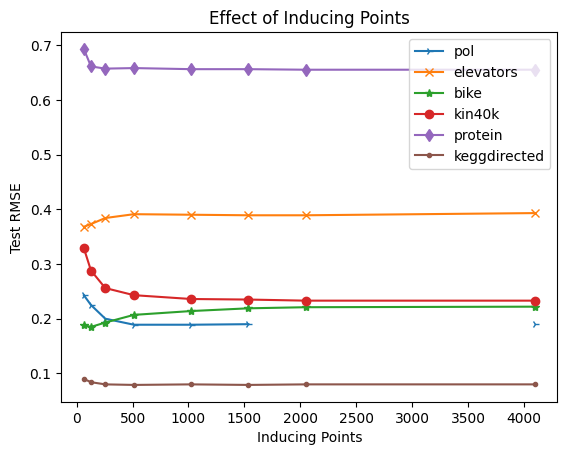

In [40]:
for dataset, _, _, _ in uci_info:
    if dataset in ["3droad", "houseelectric", "keggundirected", "buzz", "song", "slice"]:
        continue
    plt.plot(num_inducings, df_rmse.loc[dataset,:], label=dataset, marker=uci_markers[dataset])
plt.legend()
plt.title("Effect of Inducing Points")
plt.xlabel("Inducing Points")
plt.ylabel("Test RMSE")
plt.savefig("inducing/inducing.png")
# plt.plot(num_inducings, df_rmse.loc["Kin40k",:])

In [5]:
model = "soft-gp"
num_inducing = 512
frac = 0.9
seed = 6535

bin_df = pd.DataFrame()
bin_df[['N', 'D']] = df[['N', 'D']]
# bin_df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
for model_num_inducing in ["soft-gp-64", "soft-gp-128", "soft-gp-256", "soft-gp-512", "soft-gp-1024", "soft-gp-1536", "soft-gp-2048", "soft-gp-4096"]:
    num_inducing = int(model_num_inducing.split("-")[-1])
    total = num_inducing**2
    for b in ["0.0", "1e-20", "1e-10", "1e-05", "0.01", "0.5"]:
        bin_df[f"{b}-{model_num_inducing}-{1024}-{seed}"] = np.array(all_bins[f"{b}-{model_num_inducing}-{1024}-{seed}"]) / total
    # bin_df[f"1e-20-{model}-{num_inducing}-{frac}-{seed}"] = np.array(all_bins[f"1e-20-{model}-{num_inducing}-{frac}-{seed}"]) / (512**2)
bin_df = bin_df.sort_values(by=['D'], ascending=[True])
bin_df

,N,D,0.0-soft-gp-64-1024-6535,1e-20-soft-gp-64-1024-6535,1e-10-soft-gp-64-1024-6535,1e-05-soft-gp-64-1024-6535,0.01-soft-gp-64-1024-6535,0.5-soft-gp-64-1024-6535,0.0-soft-gp-128-1024-6535,1e-20-soft-gp-128-1024-6535,...,1e-10-soft-gp-2048-1024-6535,1e-05-soft-gp-2048-1024-6535,0.01-soft-gp-2048-1024-6535,0.5-soft-gp-2048-1024-6535,0.0-soft-gp-4096-1024-6535,1e-20-soft-gp-4096-1024-6535,1e-10-soft-gp-4096-1024-6535,1e-05-soft-gp-4096-1024-6535,0.01-soft-gp-4096-1024-6535,0.5-soft-gp-4096-1024-6535
3droad,391386,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kin40k,36000,8,0.585449,0.300781,0.084473,0.013672,0.000000,0.015625,0.000000,0.007446,...,0.235276,0.388121,0.262069,0.034889,0.003667,0.086025,0.234265,0.380354,0.260756,0.034933
Protein,41157,9,0.916504,0.046387,0.018555,0.002930,0.000000,0.015625,0.959839,0.025391,...,0.154395,0.097157,0.035909,0.010453,0.458564,0.222845,0.167119,0.102876,0.038035,0.010561
Houseelectric,1844352,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bike,15641,17,0.000000,0.012695,0.143066,0.417480,0.260254,0.166504,0.000000,0.003906,...,0.357479,0.454827,0.128623,0.016466,0.000612,0.082235,0.412809,0.392015,0.098283,0.014047
Elevators,14939,18,0.120117,0.014160,0.042480,0.224121,0.434570,0.164551,0.061768,0.021973,...,0.318672,0.399599,0.133236,0.005428,0.012771,0.134284,0.355113,0.371386,0.121465,0.004981
Keggdirected,43944,20,0.146973,0.018066,0.085938,0.104492,0.275391,0.369141,0.120483,0.050903,...,0.151602,0.338725,0.329864,0.057629,0.031817,0.060356,0.150135,0.360584,0.341783,0.055325
Pol,13500,26,0.972168,0.008301,0.002930,0.000977,0.000000,0.015625,0.984253,0.006104,...,NaN,NaN,NaN,NaN,0.616995,0.220756,0.103177,0.045969,0.011160,0.001942
Keggundirected,57247,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Buzz,524925,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
colors = COLORS * 2
markers = ['x', 'o', '.'] * 3

for dataset in ["3droad", "Kin40k", "Protein", "Houseelectric", "Bike", "Elevators", "Keggdirected", "Pol", "Keggundirected", "Buzz", "Song", "Slice"]:
    plt.figure()
    for model_num_inducing, c, m in zip(["soft-gp-64", "soft-gp-128", "soft-gp-256", "soft-gp-512", "soft-gp-1024", "soft-gp-1536", "soft-gp-2048", "soft-gp-4096"], colors, markers):
        bs = ["0.0", "1e-20", "1e-10", "1e-05", "0.01", "0.5"]
        # model_num_inducing = "soft-gp-512"
        num_inducing = int(model_num_inducing.split("-")[-1])
        style = "-" if num_inducing <= 1024 else ":"
        plt.plot(bs, [bin_df[f"{b}-{model_num_inducing}-{1024}-{seed}"][dataset] for b in bs], label=num_inducing, marker=m, color=c, linestyle=style)
    plt.legend()
    plt.title("Inducing")
    plt.ylabel("Proportion")
    plt.xlabel("Kernel Value")
    plt.savefig(f"inducing/{dataset}.png")
    plt.close()